# Days since first hospitalization

- Fit the doubling time based on all other input parameters by asking the user for 1 additional input: the number of days that have passed since the first hospitalization of a COVID19 patient.
- Allows the user to line up historical predicted hospitalizations with actuals.
- Properly seeds S, I, and R at current day by starting back at the time of the first hospitalization.
- Fitting process has the advantage of being _simple_, only requiring 1 additional input from the user.

In [4]:
%pylab inline
import pandas as pd
from typing import Dict, Generator, Tuple

Populating the interactive namespace from numpy and matplotlib


In [5]:
actual_hsp = [1,
2,
4,
4,
4,
6,
5,
6,
7,
7,
11,
9,
12,
13,
13,
13,
14,]


In [6]:
def sir(
    s: float, i: float, r: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def gen_sir(
    s: float, i: float, r: float, beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[float, float, float], None, None]:
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir(s, i, r, beta, gamma, n)


def sim_sir_df(
    s: float, i: float, r: float, beta: float, gamma: float, n_days
) -> pd.DataFrame:
    """Simulate the SIR model forward in time."""
    return pd.DataFrame(
        data=gen_sir(s, i, r, beta, gamma, n_days),
        columns=("day", "susceptible", "infected", "recovered"),
    )


def get_dispositions(
    patients: np.ndarray,
    rates: Dict[str, float],
    market_share: float,
) -> Dict[str, np.ndarray]:
    """Get dispositions of patients adjusted by rate and market_share."""
    return {
        key: patients * rate * market_share
        for key, rate in rates.items()
    }


def build_admits_df(n_days, dispositions) -> pd.DataFrame:
    """Build admits dataframe from Parameters and Model."""
    days = np.arange(0, n_days + 1)
    projection = pd.DataFrame({
        "day": days,
        **dispositions,
    })
    # New cases
    admits_df = projection.iloc[:-1, :] - projection.shift(1)
    admits_df["day"] = range(admits_df.shape[0])
    return admits_df


def build_census_df(
    admits_df: pd.DataFrame, lengths_of_stay
) -> pd.DataFrame:
    """ALOS for each category of COVID-19 case (total guesses)"""
    n_days = np.shape(admits_df)[0]
    census_dict = {}
    for key, los in lengths_of_stay.items():
        census = (
            admits_df.cumsum().iloc[:-los, :]
            - admits_df.cumsum().shift(los).fillna(0)
        ).apply(np.ceil)
        census_dict[key] = census[key]

    census_df = pd.DataFrame(census_dict)
    census_df["day"] = census_df.index
    census_df = census_df[["day", *lengths_of_stay.keys()]]
    census_df = census_df.head(n_days)
    return census_df


In [10]:
rates = {"hospitalized": 0.05,
         "icu": 0.0075,
         "ventilated": 0.005,
}

lengths_of_stay = {
        "hospitalized": 7,
         "icu": 9,
         "ventilated": 10,
}

#population_size = 4119405
market_share = .21
market=1350000
population_size = market*market_share
#n_days_since_first_hospitalized = 20
n_days_since_first_hospitalized = 17

#current_hospitalized = 32
current_hospitalized = 7212.0
#current_hospitalized = 547

current_hospitalized_array=actual_hsp

def run_projection(doubling_time):
    intrinsic_growth_rate = 2**(1/float(doubling_time)) - 1

    recovery_days = 14.0
    initial_i = 1/rates['hospitalized']/market_share
    S, I, R = population_size-initial_i, initial_i, 0
    # mean recovery rate, gamma, (in 1/days).
    gamma = 1/recovery_days

    # Contact rate, beta
    beta = (intrinsic_growth_rate+gamma)/S # {rate based on doubling time} / {initial S}

    n_days = 100
    
    raw_df = sim_sir_df(S,I,R,beta,gamma,n_days)
    i_dict_v = get_dispositions(raw_df.infected, rates, market_share)
    r_dict_v = get_dispositions(raw_df.recovered, rates, market_share)

    dispositions = {
        key: value + r_dict_v[key]
        for key, value in i_dict_v.items()
    }

    dispositions_df = pd.DataFrame(dispositions)
    admits_df = admits_df = build_admits_df(n_days, dispositions)
    census_df = build_census_df(admits_df, lengths_of_stay)
    return raw_df, admits_df, census_df

def obs_pred_diff(doubling_time):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized)**2


def obs_pred_diff_days_since(n_days_since_first_hospitalized):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized)**2

def obs_pred_diff_admits(n_days_since_first_hospitalized, doubling_time ):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## root squared difference is the loss to be optimized
    return (((current_hospitalized_array[n_days_since_first_hospitalized] - pred_current_hospitalized)**2)**0.5)

In [17]:
precision_steps=50
days_to_sim=15
doubling_times = np.linspace(1,10,precision_steps)
days=np.arange(1,days_to_sim)
data=[]
for d in days:
    for dt in doubling_times:
        values=[d, dt, obs_pred_diff_admits(d, dt)]
        #print(values)
        data.append(values)
diffs=pd.DataFrame(data, columns=['days', 'doubling time', 'diff'])
# go through diffs and add up the diff errors for each doubling time.  add this cumulative error to 
# a list for presentation


In [18]:
#DT_RMSEs=diffs.groupby('doubling time')['diff'].sum()
DT_RMSEs=diffs.groupby('doubling time', as_index=False).agg({'diff' : 'sum'})
DT_RMSEs

,doubling time,diff
0,1.000000,5326.0
1,1.183673,3571.0
2,1.367347,2079.0
3,1.551020,1170.0
4,1.734694,685.0
5,1.918367,421.0
6,2.102041,272.0
7,2.285714,183.0
8,2.469388,125.0
9,2.653061,86.0


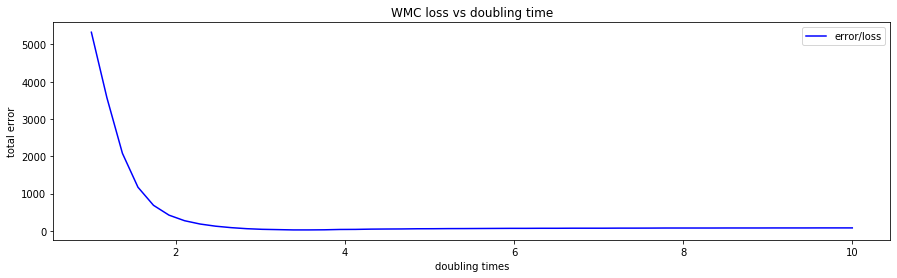

In [22]:
fig=plt.figure(figsize=(15,4))
ax=fig.add_subplot(1,1,1)
ax.label_outer()
ax.plot(DT_RMSEs['doubling time'],DT_RMSEs['diff'],label='error/loss', color='b')
ax.legend()
plt.ylabel('total error')
plt.xlabel('doubling times')
plt.title("WMC loss vs doubling time")
plt.show()

In [20]:
DT_RMSEs[DT_RMSEs['diff']==DT_RMSEs['diff'].min()]

,doubling time,diff
13,3.387755,25.0
14,3.571429,25.0


In [31]:
#TODO fix the issue where diff is the same for 2 distinct dts
fitted_doubling_time = DT_RMSEs[DT_RMSEs['diff']==DT_RMSEs['diff'].min()]["doubling time"].max()
fitted_doubling_time

3.5714285714285716

Brut force optimization, but could be implemented however. Just need to minimize the `obs_pred_diff` as a function of `doubling_times`

Then you can run the projection starting at the fitted value. This gives you a projection that starts from the day of the first hospitalization. We'll subtract off `n_days_since_first_hospitalized` to make day 0 be today.

In [32]:
raw_df, admits_df, census_df = run_projection(fitted_doubling_time)
raw_df['day'] = raw_df['day'] - n_days_since_first_hospitalized
admits_df['day'] = admits_df['day'] - n_days_since_first_hospitalized
census_df['day'] = census_df['day'] - n_days_since_first_hospitalized

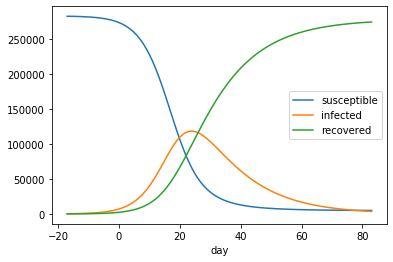

In [33]:
raw_df.set_index('day').plot()

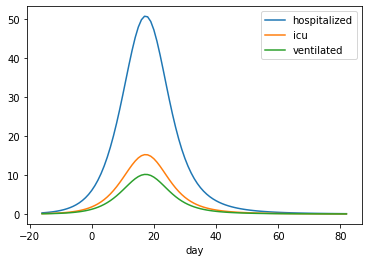

In [34]:
admits_df.set_index('day').plot()

In [35]:
actual_hsp_array = np.array(actual_hsp + [np.nan for i in range(census_df.shape[0] - len(actual_hsp))]) 
census_df['actual_hospitalized'] = actual_hsp_array

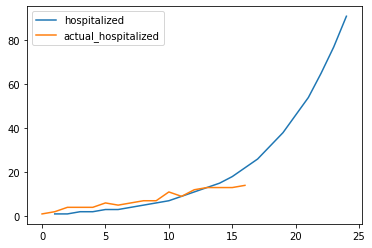

In [36]:
census_df[['hospitalized', 'actual_hospitalized']].head(25).plot()

In [37]:
census_df.set_index('day').head(30)

,hospitalized,icu,ventilated,actual_hospitalized
day,,,,
-17,NaN,NaN,NaN,1.0
-16,1.0,1.0,1.0,2.0
-15,1.0,1.0,1.0,4.0
-14,2.0,1.0,1.0,4.0
-13,2.0,1.0,1.0,4.0
-12,3.0,1.0,1.0,6.0
-11,3.0,1.0,1.0,5.0
-10,4.0,2.0,1.0,6.0
-9,5.0,2.0,1.0,7.0
